In this file, the LEAR (Lagged Error Auto-Regressive) model will be applied to forecast the price based on historical price data. This serves as a benchmark model to evaluate the performance of other more complex forecasting methods. The LEAR model will use the historical data to predict future prices and assess its effectiveness in capturing trends and fluctuations in the pricing data.

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

from functions import plot_comparison, evaluate_model

In [2]:
df = pd.read_csv('../../Data/zra_sgp_dam.csv')

# Convert the 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])
# Set the Date column as index
df.set_index('Date', inplace=True)

In [3]:
# Generate lag features
df['price_lag30d'] = df['Price (USD/MWh)'].shift(24*30)
df['price_lag30d'] = df['price_lag30d'].fillna(df['Price (USD/MWh)'])  # Fill with actual price for 30-day lag

df['price_lag60d'] = df['Price (USD/MWh)'].shift(24*60)
df['price_lag60d'] = df['price_lag60d'].fillna(df['Price (USD/MWh)'])  # Fill with actual price for 60-day lag

df['price_lag90d'] = df['Price (USD/MWh)'].shift(24*90)
df['price_lag90d'] = df['price_lag90d'].fillna(df['Price (USD/MWh)'])  # Fill with actual price for 90-day lag


Lookback = 7


In [8]:
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lookbacks = [7, 30, 60, 90]

results = []

for lookback in lookbacks:
    print(f"\n--- Lookback: {lookback} days ---")
    
    feature_col = f'price_lag{lookback}d'
    if feature_col not in df.columns:
        print(f"Missing column: {feature_col}")
        continue

    # Features and target
    X = df[[feature_col]]
    y = df['Price (USD/MWh)']

    # Train-validation-test split (70-15-15)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    # Model
    model = Lasso(alpha=0.1)

    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Evaluation Function
    def evaluate(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)

        # Directional accuracy (change in predicted vs actual direction)
        true_diff = np.diff(y_true)
        pred_diff = np.diff(y_pred)
        dae = np.mean(np.sign(true_diff) == np.sign(pred_diff))

        lower_pct = np.mean(y_pred < y_true) * 100
        return mae, rmse, r2, dae, lower_pct


    # Validation metrics
    val_mae, val_rmse, val_r2, val_dae, val_lower = evaluate(y_val, y_val_pred)
    
    # Test metrics
    test_mae, test_rmse, test_r2, test_dae, test_lower = evaluate(y_test, y_test_pred)

    # Collect results
    results.append({
        'Lookback': lookback,
        'Training Time (s)': round(training_time, 4),
        
        'Val MAE': round(val_mae, 2),
        'Val DAE': round(val_dae, 2),
        'Val RMSE': round(val_rmse, 2),
        'Val R2': round(val_r2, 2),
        # 'Val DAE': round(val_dae, 2),
        'Val Lower Predictions %': round(val_lower, 1),
        
        'Test MAE': round(test_mae, 2),
        'Test DAE': round(test_dae, 2),
        'Test RMSE': round(test_rmse, 2),
        'Test R2': round(test_r2, 2),
        # 'Test DAE': round(test_dae, 2),
        'Test Lower Predictions %': round(test_lower, 1),
    })

    # Create DataFrame of results
    results_df = pd.DataFrame(results)
    print("\nSummary Results:")
    print(results_df)



--- Lookback: 7 days ---

Summary Results:
   Lookback  Training Time (s)  Val MAE  Val DAE  Val RMSE  Val R2  \
0         7             0.0347    28.76     0.67     50.29    0.62   

   Val Lower Predictions %  Test MAE  Test DAE  Test RMSE  Test R2  \
0                     42.5     34.73      0.61      52.88     0.63   

   Test Lower Predictions %  
0                      60.0  

--- Lookback: 30 days ---

Summary Results:
   Lookback  Training Time (s)  Val MAE  Val DAE  Val RMSE  Val R2  \
0         7             0.0347    28.76     0.67     50.29    0.62   
1        30             0.0031    53.91     0.57     76.24    0.13   

   Val Lower Predictions %  Test MAE  Test DAE  Test RMSE  Test R2  \
0                     42.5     34.73      0.61      52.88     0.63   
1                     46.3     63.29      0.55      83.29     0.07   

   Test Lower Predictions %  
0                      60.0  
1                      67.7  

--- Lookback: 60 days ---

Summary Results:
   Lookback 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

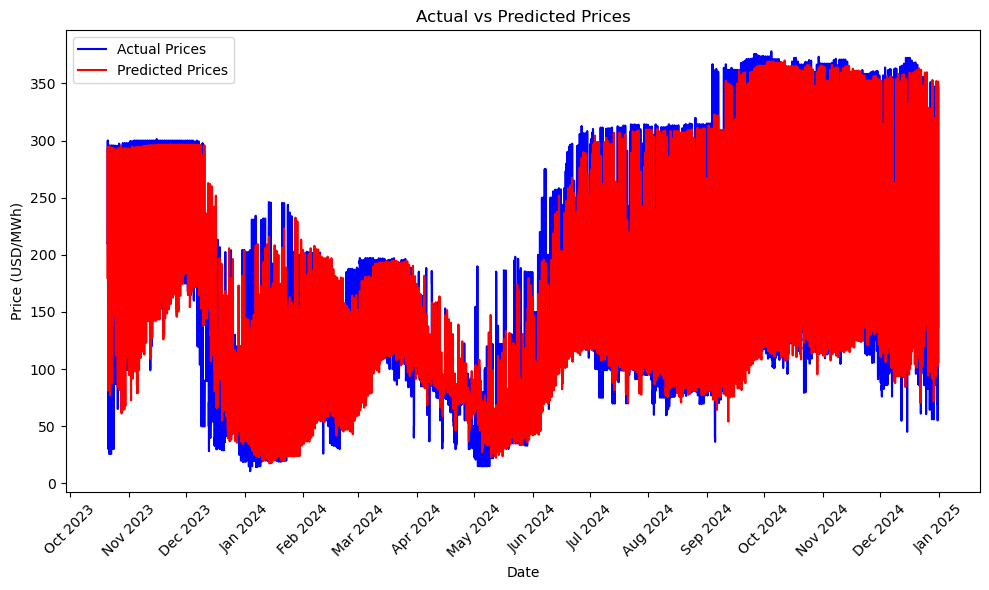

In [10]:
plot_comparison(y_test,y_test_pred,df, 'month')

In [9]:
evaluate_model(y_val, y_val_pred, y_test, y_test_pred, X_val, X_test, plot_fig=None)

,Metric,MAE,RMSE,DAE
0,Validation Set,57.643179,80.310502,47.892952
1,Test Set,70.796648,93.423210,65.699434
